In [194]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as mpl

In [333]:
geodf = gpd.read_file("Brasil.shp")
#geodf
geodf.head()

,ESTADOS,REGIAO,COD_UF,UF,geometry
0,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...
1,Alagoas,Nordeste,27.0,AL,(POLYGON ((-36.39119330741482 -10.500822065069...
2,Amapá,Norte,16.0,AP,(POLYGON ((-51.37380232136843 -0.3705300556351...
3,Amazonas,Norte,13.0,AM,POLYGON ((-73.8009788422554 -7.111452561913211...
4,Bahia,Nordeste,29.0,BA,(POLYGON ((-46.32975031667081 -13.252483567632...


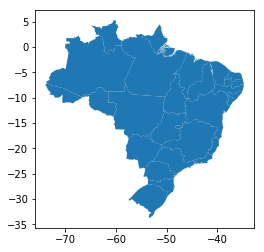

In [334]:
geodf.plot()

In [403]:
df = pd.read_csv('../DfUnic.csv')
df = df.drop(columns={df.columns[0]})
df = df.drop(columns="cod ibge")
# Colocando o nome como COD_UF para ficar ao de geodf no merge. 
df = df.rename(index=str, columns={"cod uf": "COD_UF"}) 
df.head()

,ano,região,COD_UF,uf,município,sexo,peso muito baixo,peso baixo,peso adequado,peso elevado,total
0,2009,CENTRO-OESTE,53.0,DF,BRASILIA,M,0.0,1.0,9.0,0.0,10.0
1,2009,CENTRO-OESTE,52.0,GO,ABADIA DE GOIAS,M,0.0,0.0,3.0,0.0,3.0
2,2009,CENTRO-OESTE,52.0,GO,ABADIANIA,M,0.0,1.0,12.0,1.0,14.0
3,2009,CENTRO-OESTE,52.0,GO,ACREUNA,M,0.0,0.0,24.0,3.0,27.0
4,2009,CENTRO-OESTE,52.0,GO,ADELANDIA,M,0.0,0.0,0.0,0.0,0.0


In [331]:
#states2008 = df.loc[df['ano'] == 2010]
#states2008

In [411]:
# Juntando as informações de todas as cidades por estado, de ambos os sexos. 
states_df = df.groupby(['COD_UF', 'ano'], as_index=False)[["peso muito baixo", 
                      "peso baixo", "peso adequado", "peso elevado", 
                      "total"]].sum()

# DESCOMENTAR SE: desejar fazer com que ele agrupe os dados de todos os anos juntos também
#states_df = df.groupby(['COD_UF'])[["peso muito baixo", 
#                      "peso baixo", "peso adequado", "peso elevado", 
#                      "total"]].sum()

states_df.head()

,COD_UF,ano,peso muito baixo,peso baixo,peso adequado,peso elevado,total
0,11.0,2008,9.0,22.0,1118.0,106.0,1255.0
1,11.0,2009,20.0,66.0,2694.0,367.0,3147.0
2,11.0,2010,28.0,64.0,1786.0,202.0,2080.0
3,12.0,2008,2.0,10.0,395.0,46.0,453.0
4,12.0,2009,17.0,34.0,1047.0,125.0,1223.0


In [413]:
# Fazendo o merge das informações do shapefile com o dataframe obtido pelo sisvan. 
# Assim, temos um dataframe contendo informações gerais do estado (todas as cidades)
# e de ambos os sexos, além da forma do estado, pois possui a coluna 'geometry' do shapefile
#merged = geodf.set_index('COD_UF').join(states_df)

merged = geodf.merge(states_df, on='COD_UF')
merged.head()
#merged = geodf.join(states_df)
#merged

,ESTADOS,REGIAO,COD_UF,UF,geometry,ano,peso muito baixo,peso baixo,peso adequado,peso elevado,total
0,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2008,2.0,10.0,395.0,46.0,453.0
1,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2009,17.0,34.0,1047.0,125.0,1223.0
2,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2010,18.0,46.0,928.0,95.0,1087.0
3,Alagoas,Nordeste,27.0,AL,(POLYGON ((-36.39119330741482 -10.500822065069...,2008,49.0,60.0,3135.0,520.0,3764.0
4,Alagoas,Nordeste,27.0,AL,(POLYGON ((-36.39119330741482 -10.500822065069...,2009,122.0,255.0,9312.0,1477.0,11166.0


In [414]:
merged['percentual muito baixo'] = 100 * merged['peso muito baixo'] / merged['total']
merged.head()

,ESTADOS,REGIAO,COD_UF,UF,geometry,ano,peso muito baixo,peso baixo,peso adequado,peso elevado,total,percentual muito baixo
0,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2008,2.0,10.0,395.0,46.0,453.0,0.441501
1,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2009,17.0,34.0,1047.0,125.0,1223.0,1.390025
2,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2010,18.0,46.0,928.0,95.0,1087.0,1.655934
3,Alagoas,Nordeste,27.0,AL,(POLYGON ((-36.39119330741482 -10.500822065069...,2008,49.0,60.0,3135.0,520.0,3764.0,1.301807
4,Alagoas,Nordeste,27.0,AL,(POLYGON ((-36.39119330741482 -10.500822065069...,2009,122.0,255.0,9312.0,1477.0,11166.0,1.092603


In [421]:
#Pegando informações apenas do ano desejado
merged2008 = merged.loc[merged['ano'] == 2008]
merged2008.head()

,ESTADOS,REGIAO,COD_UF,UF,geometry,ano,peso muito baixo,peso baixo,peso adequado,peso elevado,total,percentual muito baixo
0,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2008,2.0,10.0,395.0,46.0,453.0,0.441501
3,Alagoas,Nordeste,27.0,AL,(POLYGON ((-36.39119330741482 -10.500822065069...,2008,49.0,60.0,3135.0,520.0,3764.0,1.301807
6,Amapá,Norte,16.0,AP,(POLYGON ((-51.37380232136843 -0.3705300556351...,2008,0.0,12.0,300.0,11.0,323.0,0.000000
9,Amazonas,Norte,13.0,AM,POLYGON ((-73.8009788422554 -7.111452561913211...,2008,25.0,98.0,2012.0,275.0,2410.0,1.037344
12,Bahia,Nordeste,29.0,BA,(POLYGON ((-46.32975031667081 -13.252483567632...,2008,124.0,336.0,13468.0,1766.0,15694.0,0.790111


Text(0.1,0.08,'Fonte: Relatórios do SISVAN (DATASUS), 2008-2018')

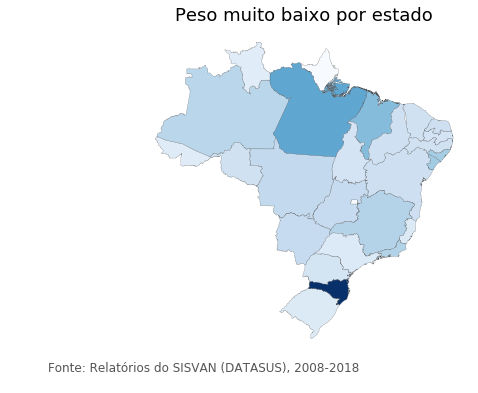

In [420]:
variable = 'percentual muito baixo'
#vmin, vmax = 0, 5 # A range do mapa coroplético
fig, ax = mpl.subplots(1, figsize=(10, 6))
merged2008.plot(column=variable, cmap='Blues', linewidth=0.2, ax=ax, edgecolor='0.3')
ax.axis('off')
ax.set_title('Peso muito baixo por estado', fontdict={'fontsize': '18'})
ax.annotate('Fonte: Relatórios do SISVAN (DATASUS), 2008-2018', xy=(0.1, .08), xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')